In [14]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import json

In [15]:
def smape(predictions, actual):
    difference = np.absolute(actual-predictions)
    summation = actual+predictions
    error = 100/len(predictions)*np.sum(2*difference/summation)
    return error

In [33]:
def fit_lstm(train):
    # reshape training into [samples, timesteps, features]
    X, y = train.iloc[:, 1:], train.iloc[:, 0]
    
    #cannot reshape datafame
    X_arrays = np.asarray(X)
    X = np.hstack(X_arrays).reshape(X.shape[0], 1, X.shape[1])

    #build model
    model = Sequential()
    model.add(LSTM(32, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit network
    history = model.fit(X, y, epochs = 50, batch_size = 1, verbose = 0, shuffle = False)
    
    return model

In [17]:
def preprocessing(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #scaling
    scaler_x = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t-1":"t-5"] = scaler_x.fit_transform(data.loc[:,"t-1":"t-5"])
    
    #need separate scaler only for target
    scaler_y = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t"] = scaler_y.fit_transform(np.asarray(data.loc[:,"t"]).reshape([-1,1]))
    
    #train/test split
    train, test = data[:int(0.7*n)], data[int(0.7*n):]    
    
    return train, test, scaler_y

In [18]:
list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
                "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
                "linear1_inc", "linear2_inc", "linear3_inc",
                "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]

Time wasted: 36.66s
-95.74672858965957


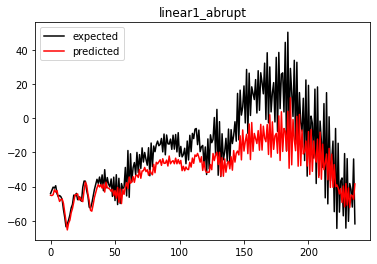

Time wasted: 41.68s
-14.288955143075237


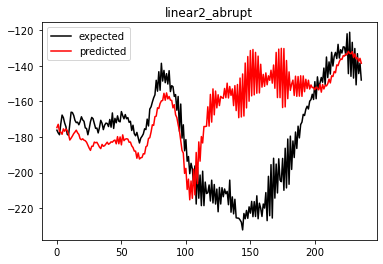

Time wasted: 45.40s
-196.29958135593395


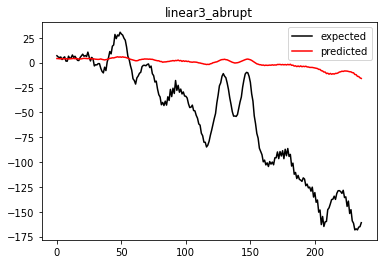

Time wasted: 40.56s
140.60592678840098


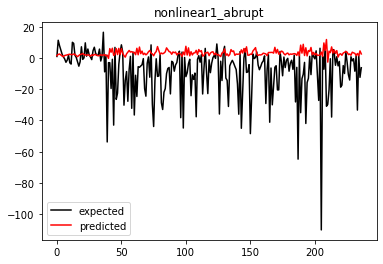

Time wasted: 40.26s
110.45631470138402


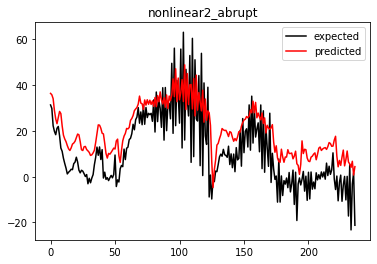

Time wasted: 40.90s
-95.64406376270955


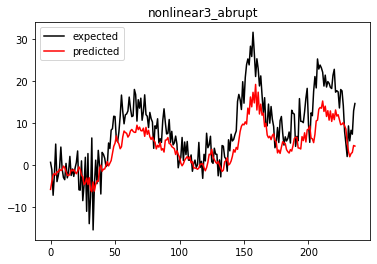

Time wasted: 37.57s
-60.75870199588099


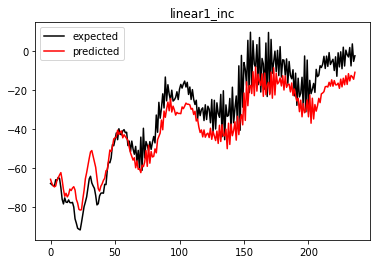

Time wasted: 36.30s
-1012.1048570041412


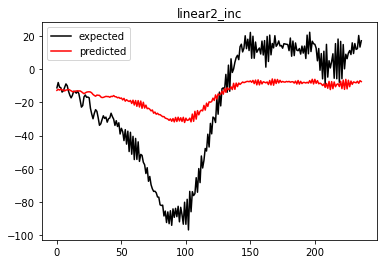

Time wasted: 48.48s
23.243258911904487


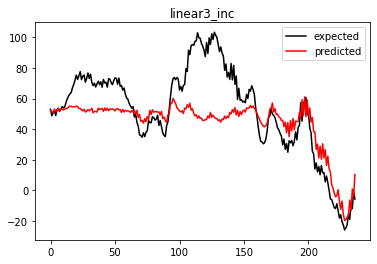

Time wasted: 50.62s
106.60157254479309


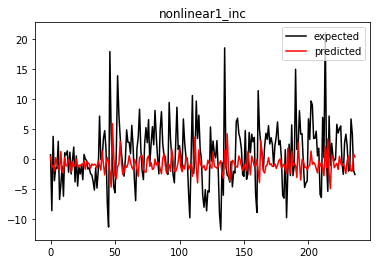

Time wasted: 49.70s
122.57939616808616


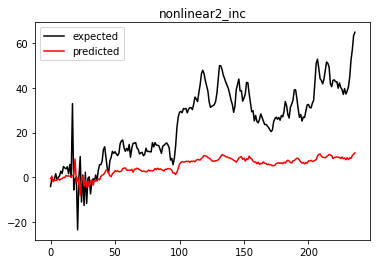

Time wasted: 59.52s
274.12111866952824


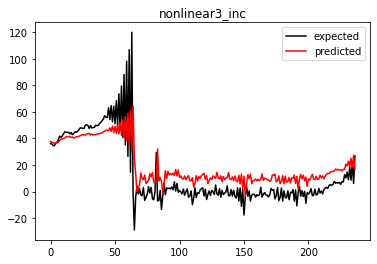

In [44]:
smape_dict_without = {}

for name in list_of_names:
    #loading the data
    file_path = "data/"+name
    data = pd.read_csv(file_path)
    
    #need this for error computation and plotting
    ground_truth = data.loc[int(0.7*len(data)):, "t"]
    
    #simple preprocessing
    train, test, scaler = preprocessing(data)
    
    #need to reshape test data
    X = test.loc[:,"t-1":"t-5"]
    X_arrays = np.asarray(X)
    test_X = np.hstack(X_arrays).reshape(X.shape[0], 1, X.shape[1])
    
    #fitting and plotting with concept
    start = time.perf_counter()
    model = fit_lstm(train.loc[:,"t":"t-5"])
    
    #if you just pass test_X to model.predict() it only returns 8 values???
    predictions = []
    for i in range(len(test_X)):
        prediction = model.predict(test_X[i,:,:].reshape(1,1,5))[0]
        predictions.append(prediction)
    end = time.perf_counter()
    print("Time wasted: {:.2f}s".format((end-start)))
    
    #need to get predictions to original scale
    predictions = scaler.inverse_transform(np.asarray(predictions).reshape([-1,1]))
    
    error = smape(predictions, ground_truth.reset_index(drop = True).values.reshape([-1,1]))
    smape_dict_without[name] = error
    
    print(error)
    plt.plot(ground_truth.reset_index(drop = True), label = "expected", color = "black")
    plt.plot(predictions, label = "predicted", color = "red")
    plt.legend()
    plt.title(name)
    
    #saving the plots
    image_path = "forecasting_results/lstm/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()
    
dict_path = "forecasting_results/lstm/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict_without))